# Interactive Simulation Study
***Sean Steinle***

In this notebook, we walk through both non-adaptive and adaptive versions of the Metropolis-Hastings algorithms. The core metric by which we compare the two algorithms is the rate of convergence, which is measured via a combination of visual inspection and autocorrelation. Because this is a simulation study, we seek to recover true parameters from randomly generated data.

## Table of Contents
1. [Non-Adaptive Metropolis-Hastings](#Non-Adaptive-Metropolis-Hastings)
2. [Adaptive Metropolis-Hastings](#Adaptive-Metropolis-Hastings)

In [1]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential, gamma
import scipy as sc
from scipy import stats
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt

## Non-Adaptive Metropolis-Hastings

In [2]:
#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=0.5, adaptive: bool=False):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta, Y = start_theta, []
    for b in range(B): #burnin samples
        if adaptive:
            results = adaptive_step(data, theta, search_breadth, Y)
            theta, Y = results['theta'], results['Y']
        else:
            results = step(data, theta, search_breadth)
            theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        if adaptive:
            results = adaptive_step(data, theta, search_breadth, Y)
            theta, Y = results['theta'], results['Y']
        else:
            results = step(data, theta, search_breadth)
            theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    acceptance_log_prob = calc_acceptance_prob(theta, theta_prime, data, search_breadth) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    return {'accepted': accepted, 'acceptance_prob': acceptance_prob, 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance log-probability by using a Bayesian linear model. Note: all terms are in log-values here,
    so must be exponentiated before determining acceptance against u."""    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.logpdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.sum(likelihoods) #use log likelihood for stability

def prior(theta: tuple):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    ab_prior = sc.stats.multivariate_normal.logpdf([a,b], [0,0], [[100,0],[0,100]]) #cov defaults to 1
    sigma_prob = sc.stats.gamma.logpdf(sigma, 1, 1)
    return np.sum([ab_prior,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple, search_breadth: float):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new_ab = sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])
    old_given_new_sigma = sc.stats.gamma.logpdf(sigma, sigma_p*search_breadth*500, scale=1/(500*search_breadth))
    old_given_new = old_given_new_ab + old_given_new_sigma
    
    new_given_old_ab = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b],[[search_breadth**2,0],[0,search_breadth**2]])
    new_given_old_sigma = sc.stats.gamma.logpdf(sigma_p, sigma*search_breadth*500, scale=1/(500*search_breadth))
    new_given_old = new_given_old_ab - new_given_old_sigma

    return old_given_new - new_given_old

#viz functions
def plot_convergence(df: pd.DataFrame):
    """Shows convergence of theta for a given results dataframe."""
    plt.plot(range(len(df)),df['a'], label='slope')
    plt.plot(range(len(df)),df['b'], label='intercept')
    plt.plot(range(len(df)),df['sigma'], label='variance')
    plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    
#highest level functions to coordinate runs
def compare_convergences(starting_positions: list, data: np.ndarray, n_samples: int=20000, adaptive: bool=False, out_dir: str=''):
    """High-level function that coordinates many rounds of the Metropolis-Hastings algorithm,
    each starting at a different position."""
    dfs = []
    for start in starting_positions:
        print(f"working on {start}")
        samples = sample(data, n_samples, 0, start, 0.1, adaptive) #no burn-in, breadth of search should be 0.1 -- yields a 5% acceptance rate at convergence

        #aggregate this run's results into dataframe
        df = pd.DataFrame(samples)
        df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
        df['start'] = str(start) #if this breaks just use an index and map
        df = df.drop(['theta'], axis=1)
        dfs.append(df) #append to the larger results df
        
    df = pd.concat(dfs)
    
    #estimation of parameter over time plots
    for param in ['a','b','sigma']:
        for start_val in df['start'].unique(): #there's definitely a more groupby-y way to do this but this will work!
            param_from_start = df[df['start']==start_val][param]
            plt.plot(range(len(param_from_start)), param_from_start, label=start_val)
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel(param)
        plt.title(f"Evolution of {param.upper()} Parameter Estimate from Different Starts")
        plt.savefig(f'{out_dir}{param}_estimate_evolution_{"adaptive" if adaptive else "nonadaptive"}.jpg', bbox_inches='tight')
        plt.show()
        plt.clf()
        
    #autocorrelation plots (I use the ACF metric from statsmodels, see more here: https://github.com/statsmodels/statsmodels/blob/c22837f0632ae8890f56886460c429ebf356bd9b/statsmodels/tsa/stattools.py#L579)
    lag = n_samples/10
    for param in ['a','b','sigma']:
        for start_val in df['start'].unique(): #there's definitely a more groupby-y way to do this but this will work!
            param_from_start = acf(df[df['start']==start_val][param],nlags=lag)
            plt.plot(range(len(param_from_start)), param_from_start, label=start_val)
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel(f'Autocorrelation with Lag {lag}')
        plt.title(f"Autocorrelation for {param.upper()} Parameter Estimate from Different Starts")
        plt.savefig(f'{out_dir}{param}_autocorrelation_{"adaptive" if adaptive else "nonadaptive"}.jpg', bbox_inches='tight')
        plt.show()
        plt.clf()
        
    df.to_csv(f'{out_dir}results.csv')
    return df

Taking a single step, you'll see that we get back a new sample with some acceptance probability and an acceptance decision.

In [3]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
step(data,(4,0,2),0.1)

{'accepted': False, 'acceptance_prob': 0.0, 'theta': (4, 0, 2)}

Now let's try to recover some preset parameters using the algorithm. Here I set the true parameters to N(-13,19) and we start the algorithm at N(0x+0,1).

In [4]:
#if we start on the correct parameters (so theoretically no burn-in) how does our acceptance rate vary with breadth value?
X = np.random.rand(10000)
Y = np.random.normal(-13,19,10000)
data = np.vstack((X,Y))
samples = sample(data, 20000, 0, (0,0,1), 0.1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-2-86e37a040ff0>:28: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


In [5]:
accepted,rejected = df[df['accepted']],df[~df['accepted']]

In [6]:
print(f"Naive Acceptance Rate: {len(accepted)/len(df)}")

Naive Acceptance Rate: 0.11135


In [7]:
accepted

,accepted,acceptance_prob,a,b,sigma
1,True,1.000000,0.012512,-0.203840,1.328383
4,True,1.000000,-0.238539,-0.310560,1.384633
6,True,1.000000,-0.313688,-0.380822,1.519772
8,True,1.000000,-0.405093,-0.430513,1.686440
10,True,1.000000,-0.489806,-0.265136,1.729874
...,...,...,...,...,...
19971,True,0.977197,-0.082987,-13.044584,19.259830
19982,True,0.121770,-0.107805,-12.931871,19.020079
19988,True,0.546770,-0.156475,-12.907471,19.327579
19992,True,0.645252,-0.037764,-12.960115,19.224431


In [8]:
rejected

,accepted,acceptance_prob,a,b,sigma
0,False,0.000000e+00,0.000000,0.000000,1.000000
2,False,0.000000e+00,0.012512,-0.203840,1.328383
3,False,0.000000e+00,0.012512,-0.203840,1.328383
5,False,0.000000e+00,-0.238539,-0.310560,1.384633
7,False,0.000000e+00,-0.313688,-0.380822,1.519772
...,...,...,...,...,...
19994,False,2.057873e-07,-0.037764,-12.960115,19.224431
19995,False,1.537939e-01,-0.037764,-12.960115,19.224431
19996,False,3.963024e-01,-0.037764,-12.960115,19.224431
19997,False,1.102555e-01,-0.037764,-12.960115,19.224431


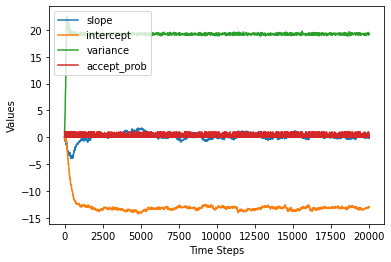

In [9]:
plot_convergence(df)

In [10]:
convergence_point = 2000
df[convergence_point:]['accepted'].sum()/(len(df)-convergence_point)

0.103

We see that we converge to the correct parameters fairly quickly, in under 1,000 timesteps for all three parameters. If we're conservative and say we converged at timestep 2,000, our algorithm yields an 11% acceptance rate at our stationary distribution.

Now let's do a full run starting at various distances from the true parameters. We should see that the chains starting at further distances from our original parameters take longer to converge.

working on (0, 0, 1)
working on (0, 10, 2)
working on (0, 20, 4)
working on (0, 30, 6)
working on (0, 40, 8)
working on (0, 50, 10)


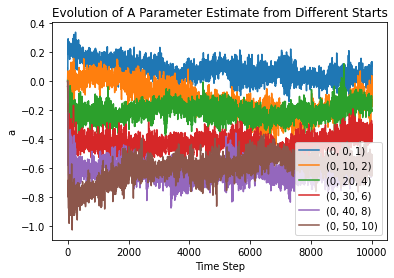

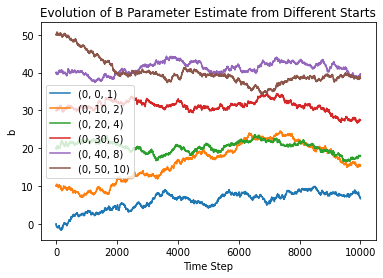

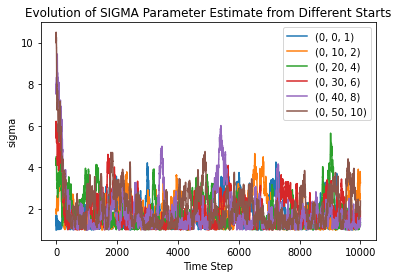

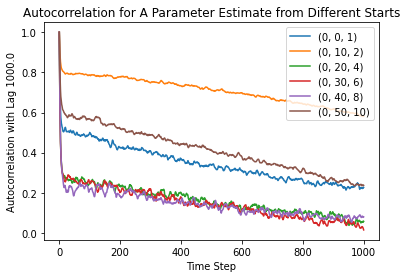

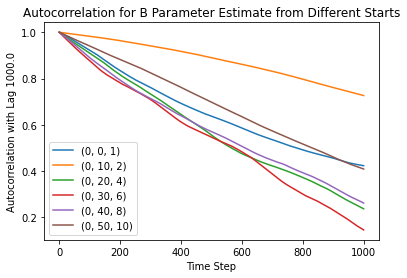

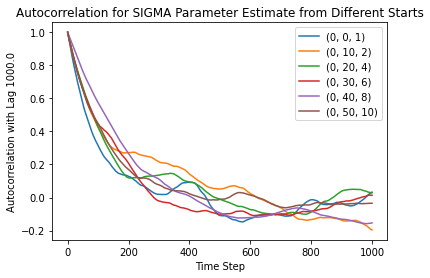

<Figure size 432x288 with 0 Axes>

In [11]:
#setting the data to our true parameters which the algorithm will recover
mu,sigma = (50,10)
X = np.random.rand(10000)
Y = np.random.normal(mu,sigma,10000)
data = np.vstack((X,Y))
df = compare_convergences([(0,0,1),(0,10,2),(0,20,4),(0,30,6),(0,40,8),(0,50,10)], (50,10), 10000, False, '../results/simulation_study/notebook/')

From these plots, it seems like the number of timesteps to converge is linear in the difference between the starting parameters and the true parameters. Let's see if we can do better with an adaptive Metropolis-Hastings algorithm!

I should note that the autocorrelation plots are inconsistent in their effectiveness--they seem to work well for demonstrating the difference in convergence rates for sigma, but the water is muddier in describing our a and b parameters. For this reason, I prefer using visual inspection for elbow points rather than relying solely on crossing some arbitrary threshold of a convergence metric.

## Adaptive Metropolis-Hastings

In [12]:
#adaptive metropolis-hastings functions (Python NEEDS multiple dispatch!)
def adaptive_step(data: np.ndarray, theta: tuple, search_breadth: float, Y):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = adaptive_sample_theta(theta, search_breadth, Y) #sample a new set of parameters
    acceptance_log_prob = adaptive_calc_acceptance_prob(theta, theta_prime, data, search_breadth, Y) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    #TODO: must determine whether to append to Y, add to return dictionary.
    return {'accepted': accepted, 'acceptance_prob': acceptance_prob, 'theta': theta_prime if accepted else theta, 'Y': Y} #return results, update theta if samples accepted

def adaptive_sample_theta(theta: tuple, search_breadth: float, Y):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    #TODO: should incorporate the history vector Y here.
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def adaptive_calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float, Y):
    """Calculates acceptance log-probability by using a Bayesian linear model. Note: all terms are in log-values here,
    so must be exponentiated before determining acceptance against u."""
    #TODO: should incorporate the history vector Y here.
    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

In [13]:
X = np.random.rand(10000)
Y = np.random.normal(-13,19,10000)
data = np.vstack((X,Y))
samples = sample(data, 10000, 0, (0,0,1), 0.1, True)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)
df

<ipython-input-12-854cccbe4e09>:6: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


,accepted,acceptance_prob,Y,a,b,sigma
0,False,0.000000,[],0.000000,0.000000,1.000000
1,True,1.000000,[],0.076579,-0.052602,1.210056
2,False,0.000000,[],0.076579,-0.052602,1.210056
3,True,1.000000,[],0.033290,-0.014997,1.293607
4,True,1.000000,[],-0.063212,0.125816,1.438953
...,...,...,...,...,...,...
9995,False,0.000015,[],-1.871378,-11.735639,18.950853
9996,False,0.399883,[],-1.871378,-11.735639,18.950853
9997,False,0.324191,[],-1.871378,-11.735639,18.950853
9998,False,0.000085,[],-1.871378,-11.735639,18.950853


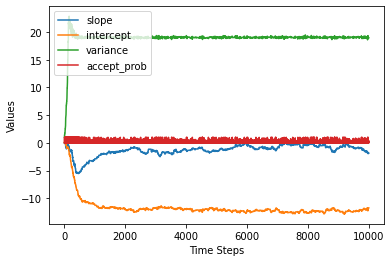

In [14]:
plot_convergence(df)

In [15]:
accepted,rejected = df[df['accepted']],df[~df['accepted']]

In [16]:
accepted[['a','b','sigma']][:100].mean()

a        -0.705362
b        -1.193621
sigma    13.777279
dtype: float64

In [17]:
rejected[['a','b','sigma']][:100].mean()

a        -0.591562
b        -0.849669
sigma    11.219614
dtype: float64

We can see here that in the burn-in section, the accepted parameters are obviously closer to the value of the real parameters. So how to use this knowledge to push us to the true parameters faster?

One idea is to use the averages of the accepted parameters as our prior. This should have the intended effect of speeding up convergence while also having the attractive quality of being an insignificant factor after convergence--that is, the likelihood overwhelms the prior at the stationary distribution.

In [18]:
#adaptive metropolis-hastings functions (Python NEEDS multiple dispatch!)
def adaptive_step(data: np.ndarray, theta: tuple, search_breadth: float, Y: list):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = adaptive_sample_theta(theta, search_breadth, Y) #sample a new set of parameters
    acceptance_log_prob = adaptive_calc_acceptance_prob(theta, theta_prime, data, search_breadth, Y) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    if accepted:
        theta = theta_prime
        Y.append(theta_prime)
    return {'accepted': accepted, 
            'acceptance_prob': acceptance_prob,
            'theta': theta,
            'Y': Y}

def adaptive_sample_theta(theta: tuple, search_breadth: float, Y: list):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def adaptive_calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float, Y: list):
    """Calculates acceptance log-probability by using a Bayesian linear model. Note: all terms are in log-values here,
    so must be exponentiated before determining acceptance against u."""
    avg_accepted_theta = (0,0,1)
    if len(Y) > 0:
        accepted_a,accepted_b,accepted_sigma = zip(*Y)
        avg_accepted_theta = (np.mean(accepted_a),np.mean(accepted_b),np.mean(accepted_sigma))
    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(avg_accepted_theta) if len(Y) > 0 else prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

In [19]:
X = np.random.rand(10000)
Y = np.random.normal(50,10,10000)
data = np.vstack((X,Y))
samples = sample(data, 5, 0, (0,0,1), 0.1, True)
adaptive_df = pd.DataFrame(samples)
adaptive_df[['a','b','sigma']] = pd.DataFrame(adaptive_df['theta'].tolist(), index=adaptive_df.index)
adaptive_df = adaptive_df.drop(['theta'], axis=1)
adaptive_df

<ipython-input-18-c8729a3f9bff>:6: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


,accepted,acceptance_prob,Y,a,b,sigma
0,True,1.0,"[(-0.08782941553059385, -0.14338573916088745, ...",-0.087829,-0.143386,1.009215
1,True,1.0,"[(-0.08782941553059385, -0.14338573916088745, ...",-0.060146,-0.005960,1.335854
2,False,0.0,"[(-0.08782941553059385, -0.14338573916088745, ...",-0.060146,-0.005960,1.335854
3,True,1.0,"[(-0.08782941553059385, -0.14338573916088745, ...",0.068053,-0.251867,1.652433
4,True,1.0,"[(-0.08782941553059385, -0.14338573916088745, ...",-0.083701,-0.368321,1.752139


In [20]:
X = np.random.rand(10000)
Y = np.random.normal(50,10,10000)
data = np.vstack((X,Y))
samples = sample(data, 10000, 0, (0,0,1), 0.1, True)
adaptive_df = pd.DataFrame(samples)
adaptive_df[['a','b','sigma']] = pd.DataFrame(adaptive_df['theta'].tolist(), index=adaptive_df.index)
adaptive_df = adaptive_df.drop(['theta'], axis=1)
adaptive_df['adaptive'] = True

samples = sample(data, 10000, 0, (0,0,1), 0.1, False)
nonadaptive_df = pd.DataFrame(samples)
nonadaptive_df[['a','b','sigma']] = pd.DataFrame(nonadaptive_df['theta'].tolist(), index=nonadaptive_df.index)
nonadaptive_df = nonadaptive_df.drop(['theta'], axis=1)
nonadaptive_df['adaptive'] = False

<ipython-input-18-c8729a3f9bff>:6: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))
<ipython-input-2-86e37a040ff0>:28: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


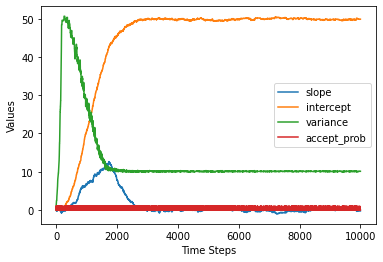

In [21]:
plot_convergence(adaptive_df)

In [22]:
adaptive_df[5000:]['accepted'].sum()

652

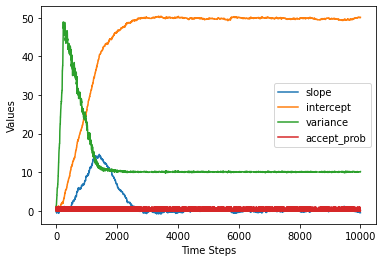

In [23]:
plot_convergence(nonadaptive_df)

In [24]:
nonadaptive_df['accepted'][5000:].sum()

624

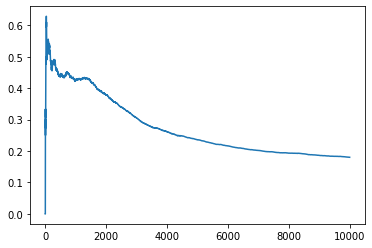

In [25]:
plt.plot(range(10000),nonadaptive_df['accepted'].expanding().mean())

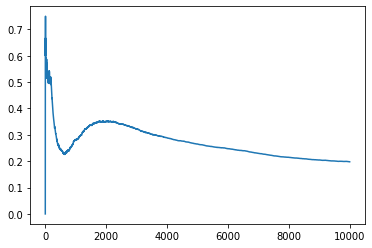

In [26]:
plt.plot(range(10000),adaptive_df['accepted'].expanding().mean())

Interestingly, we don't see much of a difference in the parameter estimations between the adaptive and non-adaptive versions. However, when we examine the cumulative average of the acceptance rate, we see where the algorithms differ. The adaptive algorithm actually gets to the same acceptance rate as convergence at around 1000 timesteps, but then it jumps up before slowly recovering to the convergence rate again.

working on (0, 0, 1)


<ipython-input-18-c8729a3f9bff>:6: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


working on (0, 10, 2)
working on (0, 20, 4)
working on (0, 30, 6)
working on (0, 40, 8)
working on (0, 50, 10)


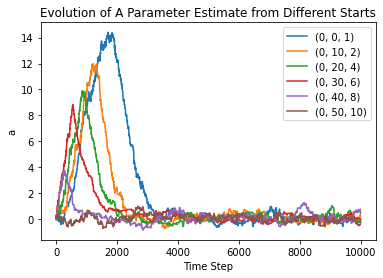

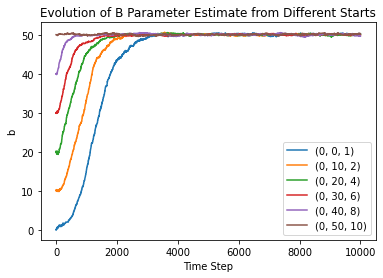

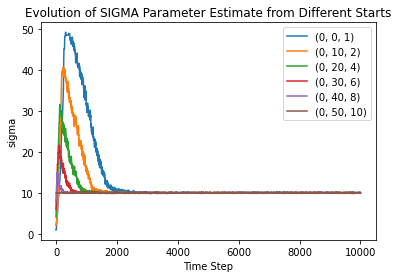

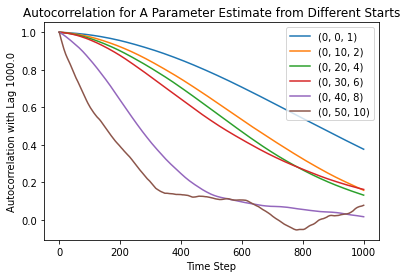

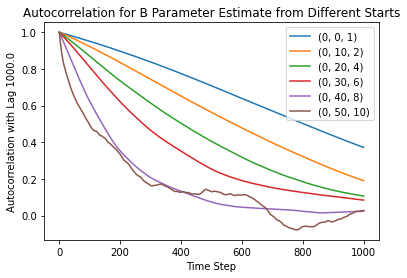

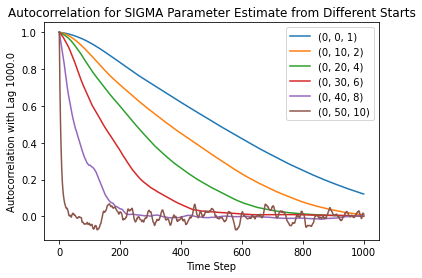

<Figure size 432x288 with 0 Axes>

In [29]:
#final test for adaptivity'    #setting the data to our true parameters which the algorithm will recover
mu,sigma = (50,10)
X = np.random.rand(10000)
Y = np.random.normal(mu,sigma,10000)
data = np.vstack((X,Y))
df = compare_convergences([(0,0,1),(0,10,2),(0,20,4),(0,30,6),(0,40,8),(0,50,10)], data, 10000, True, '../results/simulation_study/notebook/')

working on (0, 0, 1)


<ipython-input-2-86e37a040ff0>:28: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


working on (0, 10, 2)
working on (0, 20, 4)
working on (0, 30, 6)
working on (0, 40, 8)
working on (0, 50, 10)


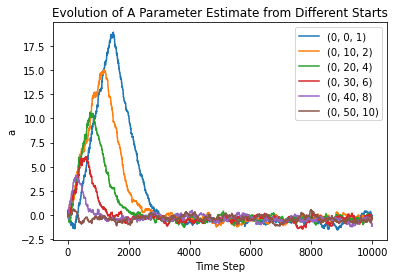

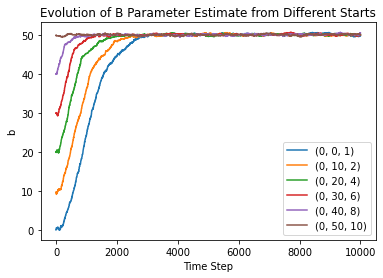

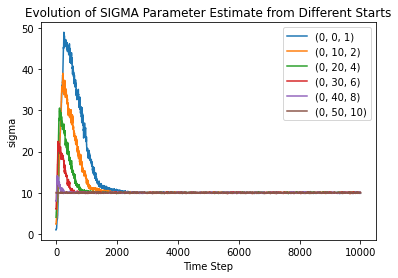

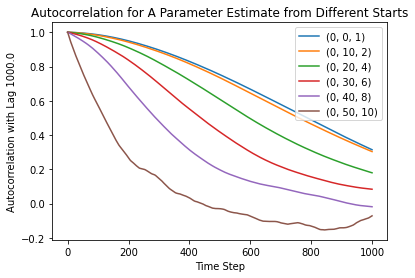

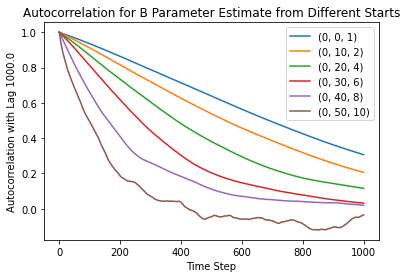

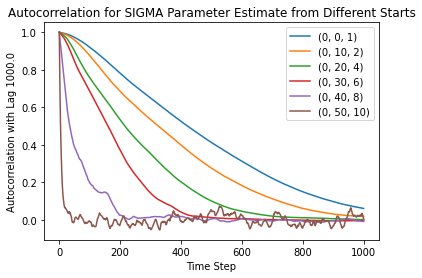

<Figure size 432x288 with 0 Axes>

In [30]:
#setting the data to our true parameters which the algorithm will recover
mu,sigma = (50,10)
X = np.random.rand(10000)
Y = np.random.normal(mu,sigma,10000)
data = np.vstack((X,Y))
df = compare_convergences([(0,0,1),(0,10,2),(0,20,4),(0,30,6),(0,40,8),(0,50,10)], data, 10000, False, '../results/simulation_study/notebook/')